In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skopt.sampler import Lhs
from math import pi
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
from tqdm import tqdm
jtplot.style()

## Objective function

In [2]:
EGG = False
LIM = 10*pi if EGG else 1

def objective2D(x,y, noise=0.0, obs=100, sigma=10):
    
    if EGG:
        x1, x2 = x,y
        noise = np.random.normal(0, scale=noise, size=len(x1))
        model = (2 + np.cos(x1/2)*np.cos(x2/2))**5
        lh = np.exp(-(model - obs)**2/(2*sigma**2))
        return lh + noise
    else:
        noise = np.random.normal(0, scale=noise, size=len(x))
        return (x**2 * np.sin(3*pi*y)**2)+noise


#### Plotting the function

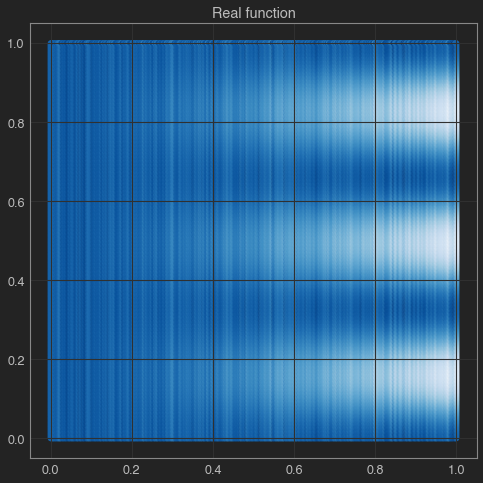

In [3]:
n = 500
x = np.random.random((n,2))
y = objective2D(x[:,0], x[:,1])

xlist = np.linspace(0, LIM, n)
ylist = np.linspace(0, LIM, n)
X_, Y_ = np.meshgrid(xlist, ylist)
y_ = objective2D(X_, Y_ , noise=0.1)
#xlist = np.linspace(0, LIM, n)
#ylist = np.linspace(0, LIM, n)
#X, Y = np.meshgrid(xlist, ylist)
#Z = objective2D(X,Y)
fig,ax=plt.subplots(1,1,figsize=(8,8))
#cp = ax.contourf(X, Y, Z, alpha = 0.3)
#fig.colorbar(cp) # Add a colorbar to a plot
#ax.set_xlabel('x (cm)')
#ax.scatter(x[:,0], x[:,1], c=y, s=20, alpha=0.6)
ax.scatter(X_, Y_, c=y_, s=30, alpha=1, cmap="Blues_r")
ax.set_title('Real function')
plt.show()

## Surrogate Function
#### Technique used to best approximate the mapping of input examples to an output score.

In [318]:
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
# define the model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
model = GaussianProcessRegressor(kernel)

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

In [319]:
# plot real observation vs surrogate function 
def plot(X, y, model):
    n=100
    xlist = np.linspace(0, LIM, n)
    ylist = np.linspace(0, LIM, n)
    X_, Y_ = np.meshgrid(xlist, ylist)
    points = np.vstack((X_.ravel(), Y_.ravel())).T
    ysamples, sigma = surrogate(model, points)
    
    fig,ax=plt.subplots(1,2,figsize=(16,8))

    #ax.set_xlabel('x (cm)')
    cp1 =ax[1].scatter(points[:,0], points[:,1], c=sigma, s=30)
    ax[1].set_title('GP sigma')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(cp1, cax=cax, orientation='vertical')
    cp2 = ax[0].scatter(points[:,0], points[:,1], c=ysamples, s=30, cmap='Blues_r')
    
    ax[0].set_title('GP prediction with {} points'.format(len(y)))
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(cp2, cax=cax, orientation='vertical')

    
    
    #ax[0].scatter(X[:,0], X[:,1],c=y,s=30, cmap='Blues_r')
    ax[0].scatter(X[:,0], X[:,1],s=20, color='Orange')
    
  
    plt.show()


## Acquisition function

In [320]:
# probability of improvement acquisition function
from scipy.stats import norm

def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:,0]
    # calcualte the probability of improvement
    probs = norm.cdf((mu - best- 0.5)/std + 1e-17)
    return probs

def opt_acquisition(X,y,model):
    # random search, generate random samples
    Xsamples = np.random.uniform(0,LIM,size=(500,2))

    #calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)

    # locate the index oinf the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix]





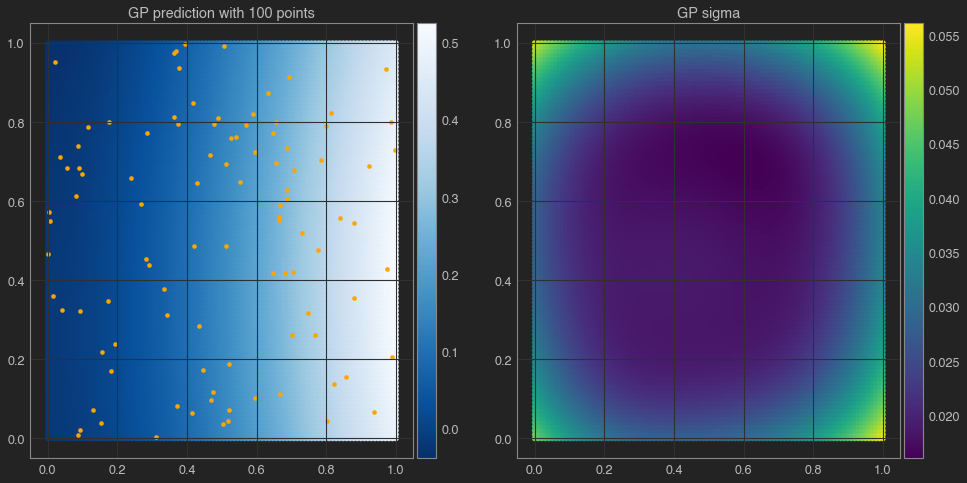

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.47it/s]


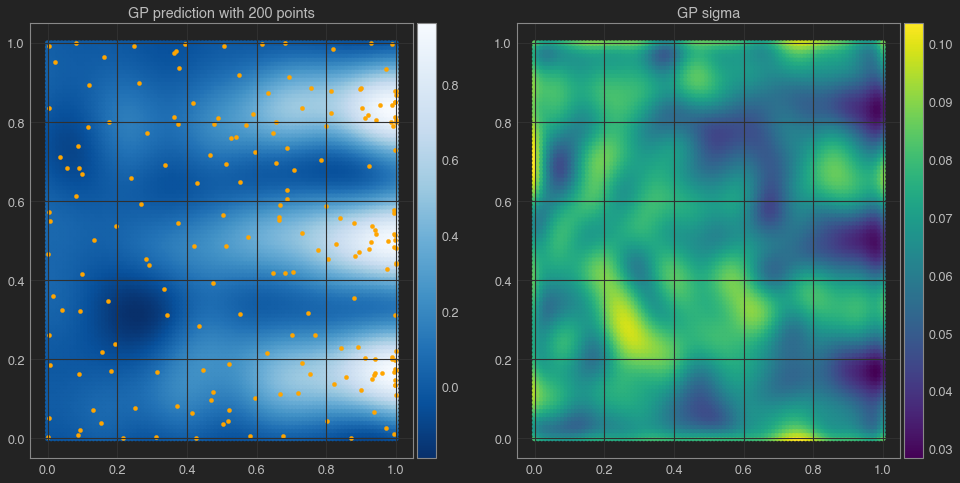

In [322]:
import warnings; warnings.simplefilter('ignore')
# Complete Bayesian Optimization Algorithm
# sample the domain sparsely with noise
X = np.random.uniform(0,LIM,size=(100,2))
y = objective2D(X[:,0], X[:,1], noise=0.1)
# reshape into rows and cols
#X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#kernel = ConstantKernel(.1) * RBF(0.1)
model = GaussianProcessRegressor(kernel, alpha=0.01 , n_restarts_optimizer=2)

# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
for i in tqdm(range(100)):
    # select the next point to sample 
    x = opt_acquisition(X, y, model)

    # sample the point
    
    actual = objective2D(np.array([x[0]]),np.array([x[1]]),noise=0)
    # summarize the finding for our own reporting 
    est, sig = surrogate(model, [x])
    #print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual), "sigma:",sig)
    # add the data to the dataset
    X = np.vstack((X, [x]))
    y = np.vstack((y, [actual]))
    # update the model
    model.fit(X,y)
plot(X, y, model)